# import package

In [1]:
''' basic package '''
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn
mnist = input_data.read_data_sets("../RNN/tmp/data/", one_hot=True)

Extracting ../RNN/tmp/data/train-images-idx3-ubyte.gz
Extracting ../RNN/tmp/data/train-labels-idx1-ubyte.gz
Extracting ../RNN/tmp/data/t10k-images-idx3-ubyte.gz
Extracting ../RNN/tmp/data/t10k-labels-idx1-ubyte.gz


Label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Data shape:  (784,)


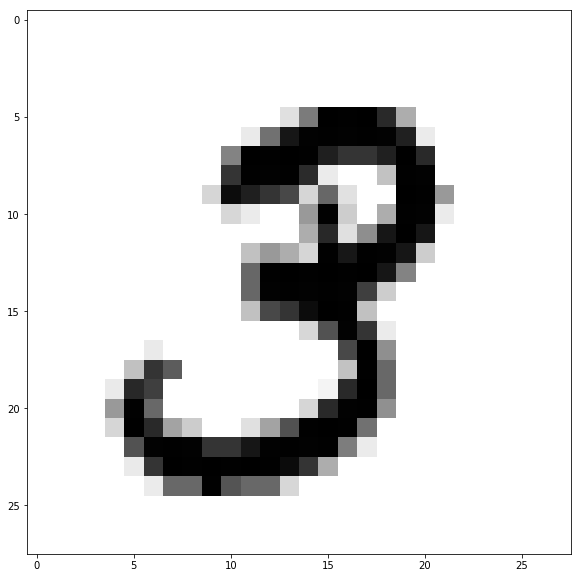

In [2]:
#show training data
print('Label: ', mnist.train.labels[1])
print('Data shape: ', mnist.train.images[1].shape)
plt.figure(figsize=(20,10))
plt.imshow(mnist.train.images[1].reshape(28, 28), cmap='binary')

# Config 

In [3]:
#define constants
#unrolled through 28 time steps
time_steps=28
#rows of 28 pixels
n_input=28
#hidden RNN units
hidden_layer_size=32
#RNN layers
number_of_layers=1
#Drop
dropout=True
#Drop rate
dropout_rate=0.8
#learning rate for adam
learning_rate=0.001
#mnist is meant to be classified in 10 classes(0-9).
n_classes=10
#size of batch
batch_size=128

# Train 

In [4]:
###RNN cell###
# def RNN_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):
def RNN_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):    
    def get_RNN(hidden_layer_size, dropout, dropout_rate):
        layer = tf.contrib.rnn.BasicRNNCell(hidden_layer_size)

        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
        return layer
    
    cell = tf.contrib.rnn.MultiRNNCell([get_RNN(hidden_layer_size, dropout, dropout_rate) for _ in range(number_of_layers)])

    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)
    
    return cell, init_state


### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行


In [5]:
import tensorflow as tf

In [6]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    ##defining placeholders##
    with tf.name_scope("inputs"):
        X=tf.placeholder(tf.float32,[None,time_steps,n_input], name='X')
        y=tf.placeholder(tf.float32,[None,n_classes], name='y')
    
    ##RNN layer##
    with tf.variable_scope("RNN_layer"):
        cell, init_state = RNN_cell(hidden_layer_size, X, number_of_layers, dropout, dropout_rate) 
        outputs, states = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)    
    
    ##output layer##
    with tf.variable_scope("output_layer"):
        RNN_last_outputs = outputs[:,-1,:]
        prediction = tf.layers.dense(inputs= RNN_last_outputs, units= n_classes)
        
    ##loss_function##
    with tf.name_scope("loss"):
        loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    
    ##optimization##
    with tf.name_scope("optimizer"):
        opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    ##model evaluation##
    with tf.name_scope("accuracy"):
        correct_prediction=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))    

    init = tf.global_variables_initializer()

### Tensorflow- 初始化模型

In [7]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [8]:
iter=1
while iter<500:
    batch_X,batch_y=mnist.train.next_batch(batch_size=batch_size)

    batch_X=batch_X.reshape((batch_size,time_steps,n_input))

    sess.run(opt, feed_dict={X: batch_X, y: batch_y})

    if iter %50==0:
        acc=sess.run(accuracy,feed_dict={X:batch_X,y:batch_y})
        los=sess.run(loss,feed_dict={X:batch_X,y:batch_y})
        print("For iter ",iter)
        print("Accuracy ", acc, "     Loss ", los)
        print("__________________")

    iter=iter+1

For iter  50
Accuracy  0.328125      Loss  1.90313
__________________
For iter  100
Accuracy  0.421875      Loss  1.7417
__________________
For iter  150
Accuracy  0.609375      Loss  1.2805
__________________
For iter  200
Accuracy  0.640625      Loss  1.16708
__________________
For iter  250
Accuracy  0.601562      Loss  1.12258
__________________
For iter  300
Accuracy  0.625      Loss  1.00597
__________________
For iter  350
Accuracy  0.664062      Loss  0.999967
__________________
For iter  400
Accuracy  0.71875      Loss  0.892671
__________________
For iter  450
Accuracy  0.703125      Loss  0.910176
__________________


In [9]:
#calculating test accuracy
test_data = mnist.test.images[:128].reshape((-1, time_steps, n_input))
test_label = mnist.test.labels[:128]
print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: test_data, y: test_label}))        

Testing Accuracy: 0.703125


In [10]:
sess.close()

## 練習
1. 把RNN cell換成LSTM觀察Accuracy是否會上升? (hint: tf.contrib.rnn.BasicLSTMCell)
2. 把RNN cell換成GRU觀察Accuracy是否會上升? (hint: tf.contrib.rnn.GRUCell)
3. 比較basic RNN、LSTM與GRU的準確度及訓練時間，並思考原因


## 進階練習
把手寫數字兩張平行輸入到model預測，輸入資料變成time_step = 28, input_data_dimension = 56

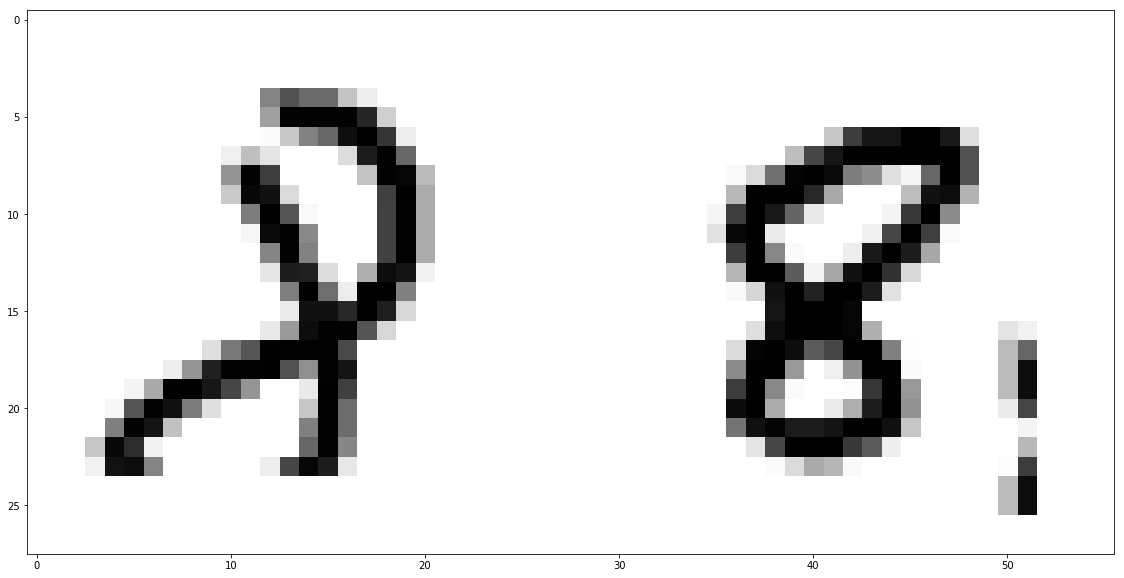

In [11]:
#show training data
plt.figure(figsize=(20,10))
img1 = mnist.train.images[0].reshape(28, 28)
img2 = mnist.train.images[5].reshape(28, 28)
img = np.concatenate((img1,img2),axis=1)  
plt.imshow(img, cmap='binary')